In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys
import datetime
import math
import numpy as np
import torch
import gpytorch
import imp

import excursion
import excursion.plotting.twodim as plots

import excursion.testcases.fast as scandetails
import excursion.optimize

import excursion.plotting.twodim as plots
import excursion.utils as utils

np.warnings.filterwarnings('ignore')

/home/irina/Documents/PROJECTS/excursion/gpytorch/lib/python3.7/site-packages/numpy/lib/index_tricks.py:185: ComplexWarning: Casting complex values to real discards the imaginary part
  nn[k] = (nn[k]*step+start)


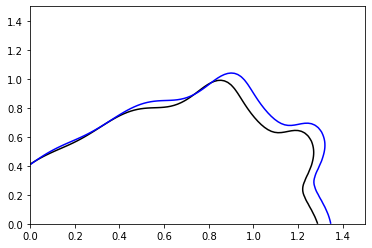

In [3]:
grid = ix,iy = scandetails.plotG
X = excursion.utils.mesh2points(grid,scandetails.plot_rangedef[:,2])

functions = [
    scandetails.truth,
    lambda X: scandetails.truth(X-0.05)
]


scandetails.truth_functions = functions


truthv = excursion.utils.values2mesh(
    scandetails.truth(X),
    scandetails.plot_rangedef,
    scandetails.invalid_region
)

contours = []
for truth_func in scandetails.truth_functions:
    contours.append(
        excursion.utils.values2mesh(
            truth_func(X),
            scandetails.plot_rangedef,
            scandetails.invalid_region
        )
    )


for cont,c in zip(contours, ['k','b']):
    plt.contour(ix,iy,cont, levels = [0], colors=[c])

In [4]:
#initialize it...
N_INIT  = 5
N_FUNCS = 2

np.random.seed(1)
X = np.random.uniform(scandetails.plot_rangedef[:,0],scandetails.plot_rangedef[:,1], size = (N_INIT,2))
y_list = [np.array([scandetails.truth_functions[i](np.asarray([x]))[0] for x in X]) for i in range(N_FUNCS)]

X = torch.tensor(X)
y_list = [torch.tensor(y) for y in y_list]

print('X_0 = ', X)
print('f(X_0) = ', y_list)

X_0 =  tensor([[6.2553e-01, 1.0805e+00],
        [1.7156e-04, 4.5350e-01],
        [2.2013e-01, 1.3851e-01],
        [2.7939e-01, 5.1834e-01],
        [5.9515e-01, 8.0823e-01]], dtype=torch.float64)
f(X_0) =  [tensor([  5.4591,   2.0052, -12.3826,  -4.1514,   0.1115], dtype=torch.float64), tensor([  5.1729,   2.2091, -13.7456,  -4.2863,  -1.1087], dtype=torch.float64)]


### 1) GP model specification
prior:
 - RBF kernel 
 - constant mean

In [5]:
# simplest form of GP model RBF with constant mean prior, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### 2) Likelihood / observational model

excursion: $\epsilon = 0$

In [6]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.tensor([0]))

## 3) Model

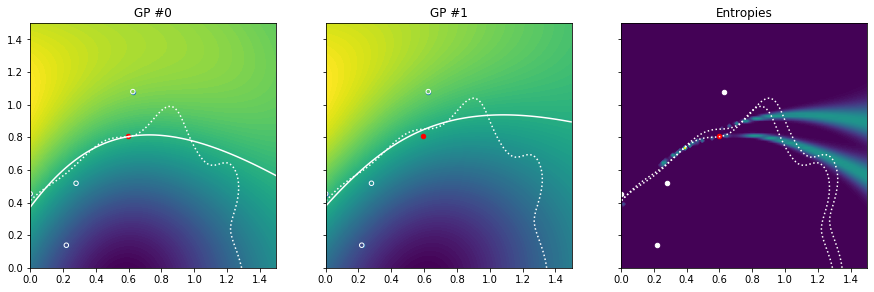

In [9]:
gps = [ExactGPModel(X,y_list[i], likelihood) for i in range(N_FUNCS)]
fig, axarr = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(15, 4.5)
plots.plot_gpytorch(axarr,gps,likelihood,X,y_list,scandetails)
# plt.savefig(os.path.join(workdir,'update_{}.png'.format(str(index).zfill(3))))
plt.show()

## 4) Acquisition of new points 

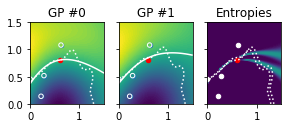

info_gain
taking new x. best non-existent index 0 [0.2625 0.525 ]
new x: [0.2625 0.525 ]
new y i: 0 -3.3974102648712
new y i: 1 -3.640873794793817


In [11]:
N_UPDATES = 1

workdir = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S-2dmulti')
os.mkdir(workdir)

for index in range(N_UPDATES):
    gps = [ExactGPModel(X,y_list[i], likelihood) for i in range(N_FUNCS)]

    fig, axarr = plt.subplots(1, 3, sharey=True)
    fig.set_size_inches(4.5, 1.5)
    plots.plot_gpytorch(axarr,gps,likelihood,X,y_list,scandetails)
    plt.savefig(os.path.join(workdir,'update_{}.png'.format(str(index).zfill(3))))
    plt.show()

    newx, acqvals = excursion.optimize.gridsearch_gpytorch(gps, X, scandetails)

    print('new x: {}'.format(newx))
    newy_list = [scandetails.truth_functions[i](np.asarray([newx]))[0] for i in range(N_FUNCS)]
    for i,newy in enumerate(newy_list):
        print('new y i: {} {}'.format(i,newy))
        y_list[i] = np.concatenate([y_list[i],[newy]])
    X = np.concatenate([X,np.array([newx])])